In [82]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.applications import InceptionV3, VGG19
import matplotlib.pyplot as plt

## Задание 1

In [78]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data3/data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


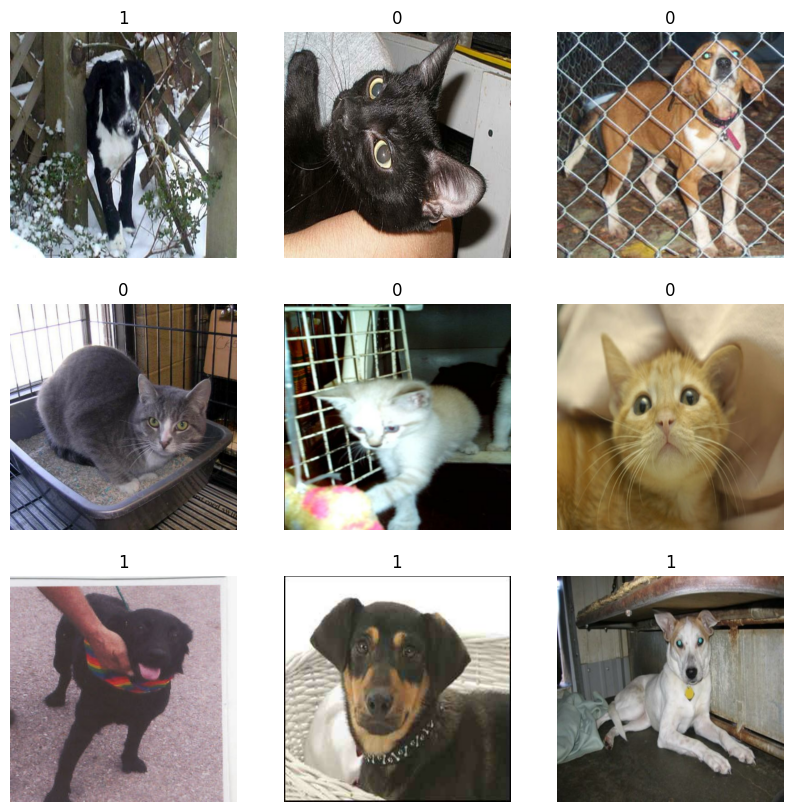

In [79]:

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [5]:
image_datagen = ImageDataGenerator(
    rescale=1./255, # Масштабирование значений пикселей в диапазон [0, 1]
    rotation_range=20, # Случайное вращение изображения на угол в диапазоне [-20, 20]
    width_shift_range=0.2, # Случайное горизонтальное смещение (доля от ширины изображения)
    height_shift_range=0.2, # Случайное вертикальное смещение (доля от высоты изображения)
    shear_range=0.2, # Случайное сдвигание (сдвиг угла сдвига в градусах)
    zoom_range=0.2, # Случайное масштабирование изображения
    horizontal_flip=True) # Случайное отражение изображения по горизонтали

In [83]:
model = tf.keras.Sequential([
    # сверточный слой Conv2D с функцией активации ReLU для извлечения признаков
    # Сверточный слой Conv2D извлекает пространственные признаки изображений с помощью свертки с ядром на входных данных
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)), 
    # Слой пулинга MaxPooling2D уменьшает размерность изображений, улавливая наиболее значимую информацию
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # плоский слой Flatten преобразует данные в одномерный вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой Dense выполняет операции линейной и нелинейной трансформации выходов предыдущего слоя.
    tf.keras.layers.Dense(64, activation='relu'),
    # Выходной слой Dense используется для получения окончательных прогнозов модели. 
    # У нас только один нейрон с функцией активации сигмоида, который представляет вероятности принадлежности к классу "собака" или "кошка".
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
image_generator = image_datagen.flow_from_directory(
    '../data3/data3',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [88]:
model.fit(image_generator, epochs=2, validation_data=test_ds)

Epoch 1/2
63/63 [==============================] - 192s 3s/step - loss: 0.6910 - accuracy: 0.5620 - val_loss: 4.4319 - val_accuracy: 0.5925
Epoch 2/2
63/63 [==============================] - 199s 3s/step - loss: 0.6779 - accuracy: 0.5920 - val_loss: 22.5155 - val_accuracy: 0.5625


In [91]:
test_loss, test_accuracy = model.evaluate(image_generator)

63/63 [==============================] - 116s 2s/step - loss: 0.6712 - accuracy: 0.6310


## Задание 2

### VGG19

In [77]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../d8/101_ObjectCategories", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 273 files belonging to 3 classes.
Using 233 files for training.
Using 40 files for validation.


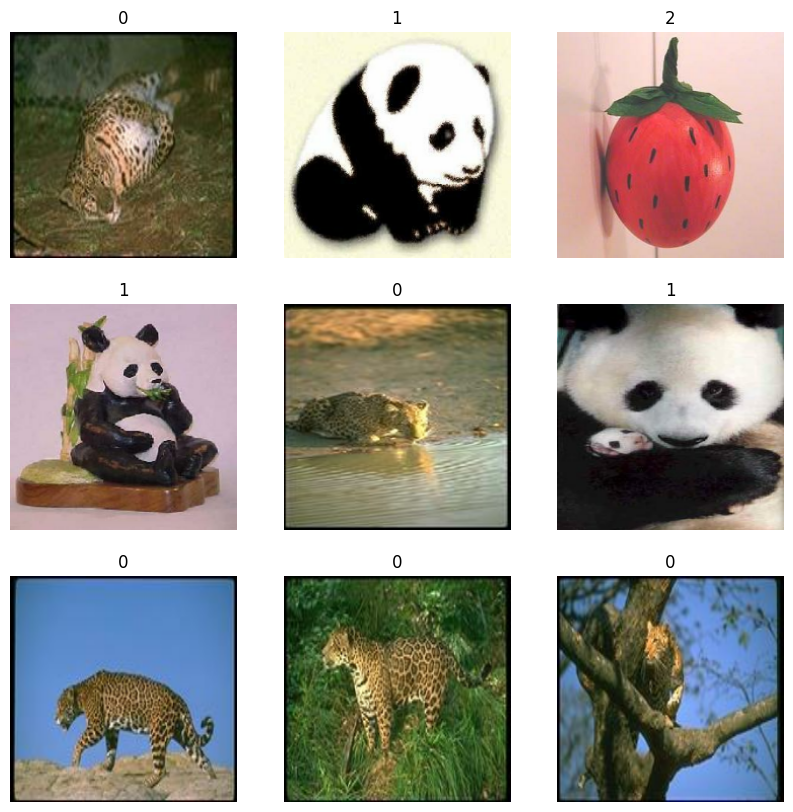

In [83]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [78]:
image_generator = image_datagen.flow_from_directory(
    '../d8/101_ObjectCategories',
    target_size=(224,224),
    batch_size=32)

Found 273 images belonging to 3 classes.


In [72]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)

In [73]:
# "заморозим" все слои, кроме последнего
for layer in vgg.layers:
    layer.trainable = False
vgg.layers[-1].trainable = True
vgg.layers[-3].trainable = True

In [79]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [80]:
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
model_vgg.fit(image_generator, epochs=2)

Epoch 1/2
9/9 [==============================] - 26s 3s/step - loss: 1.0486 - accuracy: 0.6630
Epoch 2/2
9/9 [==============================] - 26s 3s/step - loss: 0.9591 - accuracy: 0.7326


### InceptionV3

In [84]:
inv3 = InceptionV3(weights='imagenet', include_top=True)

In [85]:
# "заморозим" все слои, кроме последнего
for layer in inv3.layers:
    layer.trainable = False
inv3.layers[-1].trainable = True
inv3.layers[-3].trainable = True

In [86]:
# сохраним ссылку на входной слой сети
inp = inv3.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(inv3.layers[-2].output)

# создадим новую модель
model_new2 = tf.keras.Model(inp, out)

In [87]:
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
model_inception.fit(image_generator, epochs=2)

Epoch 1/2
9/9 [==============================] - 8s 482ms/step - loss: 1.0004 - accuracy: 0.7179
Epoch 2/2
9/9 [==============================] - 5s 546ms/step - loss: 0.8536 - accuracy: 0.7326


In [89]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions):
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(layer_sizes[i], 1) for i in range(1, self.num_layers)]

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def _feed_forward(self, x):
        activations = [x]
        zs = []
        for i in range(self.num_layers - 1):
            weight = self.weights[i]
            bias = self.biases[i]
            activation_fn = self.activation_functions[i]
            z = np.dot(weight, activations[-1]) + bias
            zs.append(z)
            if activation_fn == 'sigmoid':
                a = self._sigmoid(z)
            elif activation_fn == 'tanh':
                a = self._tanh(z)
            elif activation_fn == 'relu':
                a = self._relu(z)
            activations.append(a)
        return activations, zs

    def _backpropagate(self, x, y):
        delta_weights = [np.zeros(weight.shape) for weight in self.weights]
        delta_biases = [np.zeros(bias.shape) for bias in self.biases]
        activations, zs = self._feed_forward(x)
        delta = (activations[-1] - y)  # derivative of the loss function
        for i in range(self.num_layers - 2, -1, -1):
            z = zs[i]
            activation_fn = self.activation_functions[i]
            if activation_fn == 'sigmoid':
                derivative = self._sigmoid_derivative(z)
            elif activation_fn == 'tanh':
                derivative = self._tanh_derivative(z)
            elif activation_fn == 'relu':
                derivative = self._relu_derivative(z)
            delta_weights[i] = np.dot(delta, activations[i].T)
            delta_biases[i] = delta
            delta = np.dot(self.weights[i].T, delta) * derivative
        return delta_weights, delta_biases
        
    def update_parameters(self, delta_weights, delta_biases, learning_rate):
        self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, delta_weights)]
        self.biases = [b - learning_rate * db for b, db in zip(self.biases, delta_biases)]

    def train(self, X_train, y_train, learning_rate, num_epochs):
        for epoch in range(num_epochs):
            for x, y in zip(X_train, y_train):
                x = np.array(x, ndmin=2).T
                y = np.array(y, ndmin=2).T
                delta_weights, delta_biases = self._backpropagate(x, y)
                self.weights = [weight - learning_rate * d_weight for weight, d_weight in zip(self.weights, delta_weights)]
                self.biases = [bias - learning_rate * d_bias for bias, d_bias in zip(self.biases, delta_biases)]

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = np.array(x, ndmin=2).T
            activations, _ = self._feed_forward(x)
            predictions.append(activations[-1])
        return predictions

In [153]:
class Conv_2D:
    def __init__(self, num_filters, kernel_size):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        # Инициализация фильтров с небольшими случайными значениями
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)
    
    def _convolve(self, input, filter):
        input_size = input.shape[1]
        output_size = input_size - self.kernel_size + 1
        output = np.zeros((output_size, output_size))
        for x in range(output_size):
            for y in range(output_size):
                patch = input[:, x:x+self.kernel_size, y:y+self.kernel_size]
                output[x, y] = np.sum(patch * filter)
        return output
    
    def forward_pass(self, input):
        self.last_input = input # Сохраняем для обратного прохода
        num_examples, _, _ = input.shape
        output_size = input.shape[1] - self.kernel_size + 1
        self.feature_maps = np.zeros((num_examples, self.num_filters, output_size, output_size))
        for i in range(self.num_filters):
            for j in range(num_examples):
                self.feature_maps[j, i] = self._convolve(input[j], self.filters[i])
        return self.feature_maps
    
    def backward_pass(self, d_L_d_out, learning_rate):
        num_examples, _, _, _ = d_L_d_out.shape
        # Градиенты фильтров
        d_L_d_filters = np.zeros(self.filters.shape)
        for i in range(num_examples):
            for f in range(self.num_filters):
                for x in range(self.last_input.shape[1] - self.kernel_size + 1):
                    for y in range(self.input.shape[2] - self.kernel_size + 1):
                        patch = self.last_input[i, :, x:x+self.kernel_size, y:y+self.kernel_size]
                        d_L_d_filters[f] += d_L_d_out[i, f, x, y] * patch
        
        return d_L_d_filters # Возвращаем градиенты для дальнейших слоев
    def update_filters(self, d_L_d_filters, learning_rate):
        self.filters -= learning_rate * d_L_d_filters

In [154]:
class SimpleNN:
    def __init__(self, conv_num_filters, conv_kernel_size, pool_size, mlp_layer_sizes, activation_functions):
        self.conv_layers = [Conv_2D(conv_num_filters, conv_kernel_size)]
        self.fc_layers = MLP(mlp_layer_sizes, activation_functions)

    def _forward_pass(self, input):
        conv_output = self.conv_layers[0].forward_pass(input)
        flattened = conv_output.reshape(conv_output.shape[0], -1)
        fc_output = self.fc_layers._feed_forward(flattened)
        return fc_output

    def train(self, X_train, y_train, learning_rate, epochs):
        for epoch in range(epochs):
            for x_batch, y_batch in zip(X_train, y_train):
                output = self._forward_pass(x_batch)
                
                delta_weights, delta_biases = self.fc_layers._backpropagate(output[-1], y_batch)
                self.fc_layers.update_parameters(delta_weights, delta_biases, learning_rate)
                
                d_L_d_out = delta_weights[0]
                
                d_L_d_filters = self.conv_layers[0].backward_pass(d_L_d_out, learning_rate)
                self.conv_layers[0].update_filters(d_L_d_filters, learning_rate)

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = x[np.newaxis, :] 
            output = self.forward_pass(x)
            predictions.append(output)
        return predictions


In [155]:
conv_num_filters = 10
conv_kernel_size = 3
mlp_layer_sizes = [224,224, 3] 
activation_functions = ['relu', 'relu', 'sigmoid'] 

cnn = SimpleNN(conv_num_filters, conv_kernel_size, 2, mlp_layer_sizes, activation_functions)

In [156]:
learning_rate = 0.001
num_epochs = 2

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for X_batch, y_batch in image_generator:
        cnn.train(X_batch, y_batch, learning_rate, 1)

Epoch 1/2


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed